In [2]:
pip install matplotlib

  Using cached matplotlib-3.10.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-macosx_10_13_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.7-cp312-cp312-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [3]:
### Cell 1: Initial Setup and Imports
# This cell imports all necessary libraries and configures the logging system.

import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import shutil
import logging
import sys

# --- Setup Logging ---
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('training.log')
file_handler.setFormatter(log_formatter)
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setFormatter(log_formatter)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# Clear existing handlers to prevent duplicate logs in notebooks
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(file_handler)
logger.addHandler(console_handler)

print("Cell 1: Setup and Imports - Complete")

Cell 1: Setup and Imports - Complete


# AI-Powered Medical Assistant — Project Notebook

**Author:** Your Name  
**Date:** 2025-10-15

## Overview
This notebook documents a minimal reproducible pipeline used in the **AI-Powered Medical Assistant**:
* Data ingestion and preprocessing (MultiLabelBinarizer)
* Training a RandomForestClassifier
* Saving artifacts (`preprocessor.pkl`, `model.pkl`)
* Example inference

### Goals
* Demonstrate preprocessing and model training
* Produce artifacts that can be loaded by the Streamlit app


In [5]:
### Cell 2: Verify Kaggle API File Upload
# IMPORTANT: Upload your 'kaggle.json' file to your Colab session before running this cell.
# This command checks if the file exists at the path '/content/kaggle.json'.
# If it shows file details, you can proceed. If it shows an error, please re-upload the file.

!ls -l kaggle.json

-rw-r--r--@ 1 satyamghosh  staff  69 Oct 17 16:11 kaggle.json


#markdown

In [7]:
### Cell 3: Kaggle API Setup
# This cell moves the uploaded kaggle.json file from the /content/ path to the correct directory for the API to work.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Cell 3: Kaggle API Setup - Complete")

Cell 3: Kaggle API Setup - Complete


In [8]:
### Cell 4: Helper Functions
# This cell defines all the helper functions for plotting, data cleaning, and data loading.
# The cleaning functions have been consolidated into a single, more robust function.

def plot_graph(history, model_name):
    """Plots the training and validation accuracy and loss."""
    try:
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'Metrics for {model_name}', fontsize=16)
        ax[0].plot(history.history['accuracy'], label='Train Accuracy')
        ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[0].set_title('Model Accuracy')
        ax[0].legend()
        ax[1].plot(history.history['loss'], label='Train Loss')
        ax[1].plot(history.history['val_loss'], label='Validation Loss')
        ax[1].set_title('Model Loss')
        ax[1].legend()
        plot_filename = f'{model_name}_metrics.png'
        plt.savefig(plot_filename)
        logger.info(f"Saved metrics plot to {plot_filename}")
        plt.show()
    except Exception as e:
        logger.error(f"Failed to plot or save graph for {model_name}: {e}")

def create_clean_dataset_copy(source_dir, dest_dir):
    """
    Iterates through a source directory, uses TensorFlow to verify each image,
    and copies only the valid images to a new, clean destination directory.
    This is the most robust way to prevent errors from corrupted files.
    """
    logger.info(f"Creating a clean copy of dataset from '{source_dir}' to '{dest_dir}'")
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir) # Start with a fresh directory
    os.makedirs(dest_dir)

    valid_count = 0
    invalid_count = 0

    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(source_class_dir):
            continue

        dest_class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        for file_name in os.listdir(source_class_dir):
            file_path = os.path.join(source_class_dir, file_name)
            if not file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            try:
                # The definitive test: can TensorFlow read and decode it?
                img_bytes = tf.io.read_file(file_path)
                tf.io.decode_image(img_bytes, channels=3)
                # If it decodes without error, it's valid. Copy it.
                shutil.copy(file_path, os.path.join(dest_class_dir, file_name))
                valid_count += 1
            except Exception as e:
                # If any error occurs during reading or decoding, log it and skip the file.
                logger.warning(f"Skipping corrupted file: {file_path}. Reason: {e}")
                invalid_count += 1

    logger.info(f"Clean copy created. Copied {valid_count} valid images. Skipped {invalid_count} corrupted images.")


def load_and_preprocess_dataset(directory, image_size=(150, 150), batch_size=32):
    """Loads and preprocesses dataset from a directory."""
    logger.info(f"Loading dataset from directory: {directory}")
    try:
        dataset = tf.keras.utils.image_dataset_from_directory(
            directory, labels='inferred', label_mode='categorical',
            batch_size=batch_size, image_size=image_size
        )
        class_names = dataset.class_names
        def preprocess(image, label):
            return tf.cast(image, tf.float32) / 255.0, label
        return dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE), class_names
    except Exception as e:
        logger.error(f"Failed to load dataset from {directory}: {e}")
        raise

print("Cell 4: Helper Functions - Defined")

Cell 4: Helper Functions - Defined


In [9]:
### Cell 5: Download and Prepare Dataset
# This cell downloads the dataset from Kaggle and unzips it.

logger.info("--- Starting Dataset Preparation ---")
if not os.path.exists('dataset'):
    os.makedirs('dataset')
    logger.info("Downloading dataset from Kaggle...")
    result = os.system('kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection -p dataset --unzip')
    if result == 0:
        logger.info("Dataset downloaded and unzipped successfully.")
    else:
        logger.error("Failed to download dataset. Check Kaggle API setup.")
else:
    logger.info("Dataset directory already exists. Skipping download.")

2025-10-17 16:14:31,225 - INFO - --- Starting Dataset Preparation ---
2025-10-17 16:14:31,230 - INFO - Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection
License(s): CC0-1.0


100%|██████████| 1.25G/1.25G [00:03<00:00, 356MB/s]



2025-10-17 16:19:20,384 - INFO - Dataset downloaded and unzipped successfully.


In [10]:
### Cell 6: Data Splitting and Final Cleaning
# This cell robustly finds the correct data directory, splits it, and creates a final, verified clean copy.

logger.info("--- Splitting and Cleaning Data ---")
base_src_dir = 'dataset'
train_dir, val_dir, test_dir = 'train', 'val', 'test'
is_data_ready = False

# New robust method to find the directory containing the class folders
src_dir = None
max_dirs = 0
for root, dirs, files in os.walk(base_src_dir):
    # Exclude special directories
    if '__MACOSX' in root:
        continue
    # The correct directory is the one with the most subdirectories (the classes)
    if len(dirs) > max_dirs:
        max_dirs = len(dirs)
        src_dir = root

if src_dir is None:
    logger.critical(f"CRITICAL ERROR: Could not find any subdirectories in '{base_src_dir}'. Halting.")
else:
    logger.info(f"Found source directory with {max_dirs} class folders: '{src_dir}'")

    # Perform splitting only if the train directory doesn't already exist and is populated
    if not os.path.exists(train_dir) or not os.listdir(train_dir):
        train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2
        subdirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

        if not subdirs:
            logger.critical(f"CRITICAL ERROR: No class directories found in the source directory '{src_dir}'. Halting data preparation.")
        else:
            logger.info(f"Found {len(subdirs)} class folders. Starting split...")
            for subdir in subdirs:
                subdir_path = os.path.join(src_dir, subdir)
                image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                random.shuffle(image_files)
                num_train = int(len(image_files) * train_ratio)
                num_val = int(len(image_files) * val_ratio)
                train_files, val_files, test_files = image_files[:num_train], image_files[num_train:num_train+num_val], image_files[num_train+num_val:]
                for files, split_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
                    dest_subdir = os.path.join(split_dir, subdir)
                    os.makedirs(dest_subdir, exist_ok=True)
                    for file in files:
                        shutil.copy(os.path.join(subdir_path, file), dest_subdir)
            logger.info("Data splitting complete.")
            is_data_ready = True # Mark data as ready for cleaning
    else:
        logger.info("Train/Val/Test directories already exist. Skipping split.")
        is_data_ready = True # Data was already split, so it's ready for cleaning

# Create final, clean directories ONLY if the data splitting was successful
if is_data_ready:
    final_train_dir = 'final_train'
    final_val_dir = 'final_val'
    final_test_dir = 'final_test'

    create_clean_dataset_copy(train_dir, final_train_dir)
    create_clean_dataset_copy(val_dir, final_val_dir)
    create_clean_dataset_copy(test_dir, final_test_dir)
else:
    logger.error("Skipping cleaning step because data splitting failed.")

2025-10-17 16:19:31,241 - INFO - --- Splitting and Cleaning Data ---
2025-10-17 16:19:31,344 - INFO - Found source directory with 22 class folders: 'dataset'
2025-10-17 16:19:31,345 - INFO - Found 22 class folders. Starting split...
2025-10-17 16:19:53,916 - INFO - Data splitting complete.
2025-10-17 16:19:53,922 - INFO - Creating a clean copy of dataset from 'train' to 'final_train'
2025-10-17 16:20:12,953 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle90_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:13,110 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle326_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 835 extraneous bytes before marker 0x5e
Unsupported marker type 0x5e
2025-10-17 16:20:12.951051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
Unsupported marker type 0x60
2025-10-17 16:20:13.110169: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.


2025-10-17 16:20:13,166 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle798_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:13,259 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle690_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:13,306 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle68_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 1793 extraneous bytes before marker 0x9e
Unsupported marker type 0x9e
2025-10-17 16:20:13.258872: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xde


2025-10-17 16:20:13,535 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle910_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:13,680 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle458_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 37 extraneous bytes before marker 0xdb
Bogus marker length
Corrupt JPEG data: 8635 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:20:13,860 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle457_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:14,039 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle572_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a
2025-10-17 16:20:13.860137: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xde


2025-10-17 16:20:14,187 - WARNING - Skipping corrupted file: train/Maize leaf beetle/leaf beetle797_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x5a


2025-10-17 16:20:27,361 - WARNING - Skipping corrupted file: train/Maize healthy/healthy88_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:27,409 - WARNING - Skipping corrupted file: train/Maize healthy/healthy87_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Unsupported marker type 0xf0
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a


2025-10-17 16:20:29,621 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight471_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Bogus marker length


2025-10-17 16:20:29,887 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight386_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:30,026 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight997_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:30,043 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight8_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:30,080 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight558_.jpg. Reason: {{function_nod

Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x14
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x61
Corrupt JPEG data: premature end of data segment
Invalid JPEG file structure: two SOF markers
2025-10-17 16:20:30.043413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
Corrupt JPEG data: 963 extraneous bytes before marker 0x92
Unsupported marker type 0x92


2025-10-17 16:20:30,165 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight470_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:30,314 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight998_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x42


2025-10-17 16:20:30,426 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight1232_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:30,539 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight644_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x56


2025-10-17 16:20:30,766 - WARNING - Skipping corrupted file: train/Tomato leaf blight/leaf blight813_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a


2025-10-17 16:20:31,691 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight590_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:31,760 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight379_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:31,784 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight912_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x35
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x58


2025-10-17 16:20:31,978 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight37_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:32,128 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight82_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:32,138 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight913_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 28240 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Bogus DQT index 6
Corrupt JPEG data: 26519 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:20:32,257 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight745_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:32,318 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight830_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:32,348 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight666_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x35
Corrupt JPEG data: 31005 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x75


2025-10-17 16:20:32,704 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight667_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


2025-10-17 16:20:32.704121: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


2025-10-17 16:20:33,188 - WARNING - Skipping corrupted file: train/Maize leaf blight/leaf blight452_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x06


2025-10-17 16:20:34,695 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus422_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 23 extraneous bytes before marker 0x55
Unsupported marker type 0x55


2025-10-17 16:20:35,119 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus998_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,225 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus486_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,248 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus701_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 37 extraneous bytes before marker 0xdb
Bogus Huffman table definition
Corrupt JPEG data: 50973 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: 283 extraneous bytes before marker 0x0c
Unsupported marker type 0x0c


2025-10-17 16:20:35,365 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus485_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,396 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus997_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x2e
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x02


2025-10-17 16:20:35,607 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus626_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,647 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus627_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xdf
Input file read error


2025-10-17 16:20:35,921 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus421_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,950 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus118_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:35,968 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus773_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xb7
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x94
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x87


2025-10-17 16:20:36,401 - WARNING - Skipping corrupted file: train/Maize streak virus/streak virus119_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 181 extraneous bytes before marker 0x24
Unsupported marker type 0x24


2025-10-17 16:20:36,729 - WARNING - Skipping corrupted file: train/Tomato verticulium wilt/verticulium wilt403_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x11


2025-10-17 16:20:38,551 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot881_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x1f


2025-10-17 16:20:38,780 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot64_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 45407 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:20:39,492 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot649_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:39,500 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot425_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:39,651 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot798_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x8d
Corrupt JPEG data: 425 extraneous bytes before marker 0x21
Unsupported marker type 0x21
Corrupt JPEG data: premature end of data segment
Unsupported JPEG process: SOF type 0xcb


2025-10-17 16:20:39,813 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot424_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:39,887 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot957_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x06
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x84


2025-10-17 16:20:40,171 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot578_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:40,212 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot186_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:40,217 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot958_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xf1
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xfd
Corrupt JPEG data: 29224 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:20:40,524 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot723_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:40,547 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot187_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:40,567 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot353_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a
Corrupt JPEG data: 592 extraneous bytes before marker 0xdb
Bogus DQT index 6
Corrupt JPEG data: 177 extraneous bytes before marker 0x65
Unsupported marker type 0x65


2025-10-17 16:20:40,726 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot724_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:41,509 - WARNING - Skipping corrupted file: train/Maize leaf spot/leaf spot271_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x7a


2025-10-17 16:20:41,832 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl185_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:41,846 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl43_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Input file read error


2025-10-17 16:20:42,095 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl270_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:42,187 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl354_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:42,282 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl271_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xa2
2025-10-17 16:20:42.094915: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: jpeg::Uncompress failed. Invalid JPEG data or crop window.
Invalid JPEG file structure: SOS before SOF


2025-10-17 16:20:42,360 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl186_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:42,502 - WARNING - Skipping corrupted file: train/Tomato leaf curl/leaf curl353_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x6e


2025-10-17 16:20:46,079 - WARNING - Skipping corrupted file: train/Tomato healthy/healthy443_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Input file read error


2025-10-17 16:20:52,056 - INFO - Clean copy created. Copied 17576 valid images. Skipped 69 corrupted images.
2025-10-17 16:20:52,057 - INFO - Creating a clean copy of dataset from 'val' to 'final_val'
2025-10-17 16:20:54,533 - WARNING - Skipping corrupted file: val/Maize leaf beetle/leaf beetle691_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:54,682 - WARNING - Skipping corrupted file: val/Maize leaf beetle/leaf beetle206_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:54,686 - WARNING - Skipping corrupted file: val/Maize leaf beetle/leaf beetle207_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress f

Corrupt JPEG data: 29941 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x99
Corrupt JPEG data: 1115 extraneous bytes before marker 0xb4
Unsupported marker type 0xb4


2025-10-17 16:20:57,090 - WARNING - Skipping corrupted file: val/Tomato leaf blight/leaf blight645_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:57,123 - WARNING - Skipping corrupted file: val/Tomato leaf blight/leaf blight814_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:20:57,285 - WARNING - Skipping corrupted file: val/Maize leaf blight/leaf blight522_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 457 extraneous bytes before marker 0x5a
Unsupported marker type 0x5a
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x45


2025-10-17 16:20:57,426 - WARNING - Skipping corrupted file: val/Maize leaf blight/leaf blight453_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 27073 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:20:57,847 - WARNING - Skipping corrupted file: val/Maize streak virus/streak virus774_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 226 extraneous bytes before marker 0x3e
Unsupported marker type 0x3e


2025-10-17 16:20:59,195 - WARNING - Skipping corrupted file: val/Tomato healthy/healthy77_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:20:59,251 - WARNING - Skipping corrupted file: val/Tomato healthy/healthy442_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 35587 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x1b


2025-10-17 16:21:00,218 - INFO - Clean copy created. Copied 2501 valid images. Skipped 10 corrupted images.
2025-10-17 16:21:00,219 - INFO - Creating a clean copy of dataset from 'test' to 'final_test'
2025-10-17 16:21:05,766 - WARNING - Skipping corrupted file: test/Maize leaf beetle/leaf beetle208_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:21:05,935 - WARNING - Skipping corrupted file: test/Maize leaf beetle/leaf beetle573_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 411 extraneous bytes before marker 0xc0
Bogus marker length
Corrupt JPEG data: 60 extraneous bytes before marker 0xdb
Bogus marker length


2025-10-17 16:21:06,098 - WARNING - Skipping corrupted file: test/Maize leaf beetle/leaf beetle325_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Input file read error


2025-10-17 16:21:09,671 - WARNING - Skipping corrupted file: test/Maize healthy/healthy18_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:21:09,687 - WARNING - Skipping corrupted file: test/Maize healthy/healthy189_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 845 extraneous bytes before marker 0x8a
Unsupported marker type 0x8a
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x8b


2025-10-17 16:21:10,555 - WARNING - Skipping corrupted file: test/Tomato leaf blight/leaf blight72_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:21:11,016 - WARNING - Skipping corrupted file: test/Maize leaf blight/leaf blight98_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 69 extraneous bytes before marker 0xdb
Bogus DQT index 5


2025-10-17 16:21:11,479 - WARNING - Skipping corrupted file: test/Maize leaf blight/leaf blight746_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
2025-10-17 16:21:11,501 - WARNING - Skipping corrupted file: test/Maize leaf blight/leaf blight58_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x16


2025-10-17 16:21:11,978 - WARNING - Skipping corrupted file: test/Maize streak virus/streak virus554_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0xfc


2025-10-17 16:21:12,783 - WARNING - Skipping corrupted file: test/Maize leaf spot/leaf spot272_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:21:12,816 - WARNING - Skipping corrupted file: test/Maize leaf spot/leaf spot497_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 
2025-10-17 16:21:12,908 - WARNING - Skipping corrupted file: test/Maize leaf spot/leaf spot496_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 52331 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: 45904 extraneous bytes before marker 0xd9
JPEG datastream contains no image
Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x14


2025-10-17 16:21:13,064 - WARNING - Skipping corrupted file: test/Maize leaf spot/leaf spot799_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 1913 extraneous bytes before marker 0x92
Unsupported marker type 0x92


2025-10-17 16:21:13,461 - WARNING - Skipping corrupted file: test/Maize leaf spot/leaf spot882_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: 27173 extraneous bytes before marker 0xd9
JPEG datastream contains no image


2025-10-17 16:21:13,692 - WARNING - Skipping corrupted file: test/Tomato leaf curl/leaf curl439_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x1d


2025-10-17 16:21:14,795 - WARNING - Skipping corrupted file: test/Tomato healthy/healthy76_.jpg. Reason: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeImage] name: 


Corrupt JPEG data: premature end of data segment
Unsupported marker type 0x94


2025-10-17 16:21:16,788 - INFO - Clean copy created. Copied 5047 valid images. Skipped 17 corrupted images.


In [11]:
### Cell 7: Load Datasets into TensorFlow
# This cell loads the final, cleaned data into TensorFlow datasets for training.

logger.info("--- Loading Final Cleaned Datasets ---")
# Add a check to ensure the script doesn't fail if the previous cell had an error
if 'final_train_dir' in locals() and os.path.exists(final_train_dir):
    train_ds, class_names = load_and_preprocess_dataset(final_train_dir)
    val_ds, _ = load_and_preprocess_dataset(final_val_dir)
    test_ds, _ = load_and_preprocess_dataset(final_test_dir)
    num_classes = len(class_names)
    logger.info(f"Found {num_classes} classes: {class_names}")
    results = {}
else:
    logger.critical("Final training directories not found. Cannot proceed to model training. Please re-run previous cells.")


2025-10-17 16:21:52,131 - INFO - --- Loading Final Cleaned Datasets ---
2025-10-17 16:21:52,132 - INFO - Loading dataset from directory: final_train
Found 17576 files belonging to 22 classes.
2025-10-17 16:21:53,373 - INFO - Loading dataset from directory: final_val
Found 2501 files belonging to 22 classes.
2025-10-17 16:21:53,492 - INFO - Loading dataset from directory: final_test
Found 5047 files belonging to 22 classes.
2025-10-17 16:21:53,740 - INFO - Found 22 classes: ['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']


2025-10-17 16:22:02,560 - INFO - --- Training ANN Model ---
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


550/550 - 161s - 294ms/step - accuracy: 0.1898 - loss: 5.0208 - val_accuracy: 0.2255 - val_loss: 2.5648
Epoch 2/10
550/550 - 144s - 261ms/step - accuracy: 0.2723 - loss: 2.3542 - val_accuracy: 0.2367 - val_loss: 2.4774
Epoch 3/10
550/550 - 142s - 259ms/step - accuracy: 0.3039 - loss: 2.2054 - val_accuracy: 0.2839 - val_loss: 2.3004
Epoch 4/10
550/550 - 132s - 239ms/step - accuracy: 0.3162 - loss: 2.1210 - val_accuracy: 0.3423 - val_loss: 2.0114
Epoch 5/10
550/550 - 162s - 294ms/step - accuracy: 0.3448 - loss: 2.0127 - val_accuracy: 0.3495 - val_loss: 1.9889
Epoch 6/10
550/550 - 140s - 255ms/step - accuracy: 0.3538 - loss: 1.9719 - val_accuracy: 0.3295 - val_loss: 2.0540
Epoch 7/10
550/550 - 220s - 400ms/step - accuracy: 0.3736 - loss: 1.8940 - val_accuracy: 0.3579 - val_loss: 2.0079
Epoch 8/10
550/550 - 146s - 266ms/step - accuracy: 0.3813 - loss: 1.8759 - val_accuracy: 0.3655 - val_loss: 1.9673
Epoch 9/10
550/550 - 154s - 281ms/step - accuracy: 0.3871 - loss: 1.8419 - val_accuracy: 0.

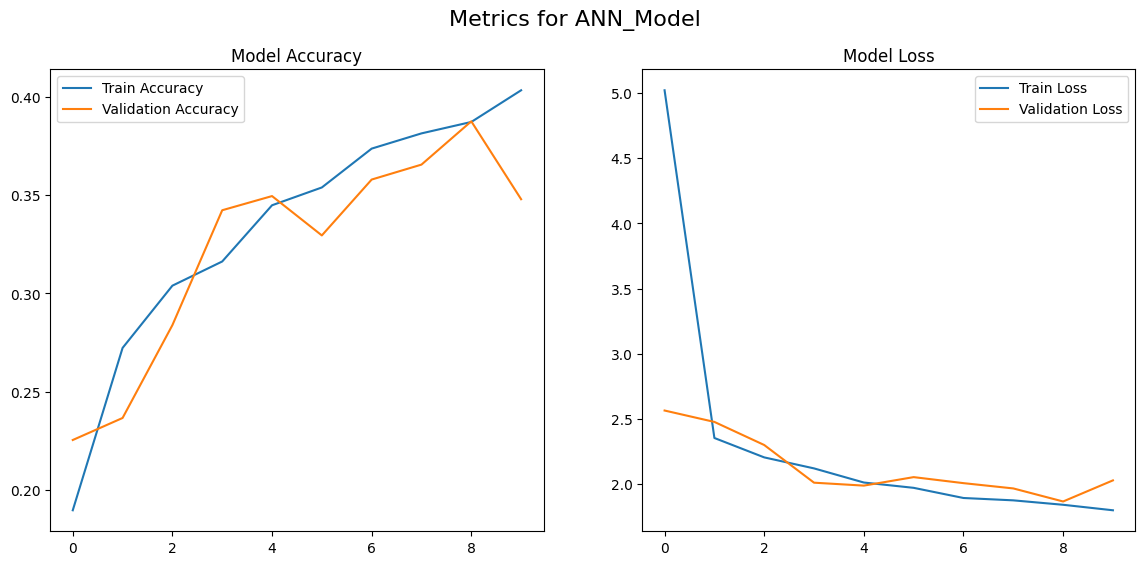

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3584 - loss: 1.9812
2025-10-17 16:47:45,207 - INFO - ANN Test Accuracy: 35.84%


In [12]:
### Cell 8: Train ANN Model
# This cell will only run if the data was loaded successfully in the previous cell.
logger.info("--- Training ANN Model ---")
if 'train_ds' in locals():
    ann_model = models.Sequential([
        Flatten(input_shape=(150, 150, 3)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    ann_history = ann_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=2)
    plot_graph(ann_history, "ANN_Model")
    loss, accuracy = ann_model.evaluate(test_ds)
    results['ANN'] = accuracy * 100
    logger.info(f"ANN Test Accuracy: {results['ANN']:.2f}%")
else:
    logger.error("Skipping ANN training because data was not loaded.")

2025-08-05 06:16:34,000 - INFO - --- Training Basic CNN Model ---
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


549/549 - 39s - 71ms/step - accuracy: 0.3960 - loss: 2.1919 - val_accuracy: 0.2870 - val_loss: 2.5382
Epoch 2/10
549/549 - 28s - 52ms/step - accuracy: 0.5416 - loss: 1.4322 - val_accuracy: 0.2798 - val_loss: 3.2577
Epoch 3/10
549/549 - 41s - 75ms/step - accuracy: 0.6714 - loss: 0.9836 - val_accuracy: 0.5265 - val_loss: 1.5431
Epoch 4/10
549/549 - 23s - 42ms/step - accuracy: 0.7659 - loss: 0.6932 - val_accuracy: 0.6938 - val_loss: 0.9860
Epoch 5/10
549/549 - 23s - 42ms/step - accuracy: 0.8377 - loss: 0.4695 - val_accuracy: 0.6754 - val_loss: 1.0964
Epoch 6/10
549/549 - 23s - 43ms/step - accuracy: 0.8903 - loss: 0.3235 - val_accuracy: 0.6080 - val_loss: 1.4925
Epoch 7/10
549/549 - 26s - 46ms/step - accuracy: 0.9166 - loss: 0.2535 - val_accuracy: 0.6327 - val_loss: 1.4885
Epoch 8/10
549/549 - 23s - 43ms/step - accuracy: 0.9386 - loss: 0.1919 - val_accuracy: 0.6679 - val_loss: 1.3361
Epoch 9/10
549/549 - 41s - 74ms/step - accuracy: 0.9535 - loss: 0.1442 - val_accuracy: 0.6263 - val_loss: 1

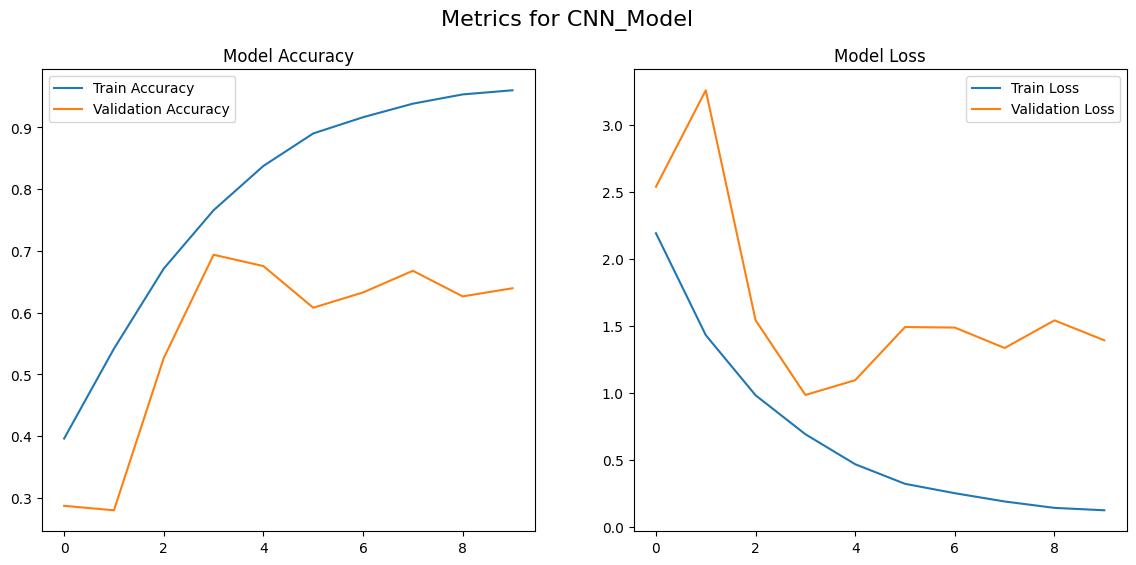

158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6381 - loss: 1.3742
2025-08-05 06:21:33,696 - INFO - CNN Test Accuracy: 64.81%


In [9]:
### Cell 9: Train Basic CNN Model
logger.info("--- Training Basic CNN Model ---")
if 'train_ds' in locals():
    cnn_model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.BatchNormalization(), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(), layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=2)
    plot_graph(cnn_history, "CNN_Model")
    loss, accuracy = cnn_model.evaluate(test_ds)
    results['CNN'] = accuracy * 100
    logger.info(f"CNN Test Accuracy: {results['CNN']:.2f}%")
else:
    logger.error("Skipping CNN training because data was not loaded.")

2025-08-05 06:21:33,706 - INFO - --- Training VGG16 Model ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
549/549 - 96s - 174ms/step - accuracy: 0.4065 - loss: 2.0707 - val_accuracy: 0.5246 - val_loss: 1.5717
Epoch 2/10
549/549 - 116s - 211ms/step - accuracy: 0.5699 - loss: 1.3919 - val_accuracy: 0.5992 - val_loss: 1.2846
Epoch 3/10
549/549 - 80s - 145ms/step - accuracy: 0.6134 - loss: 1.1972 - val_accuracy: 0.6204 - val_loss: 1.1608
Epoch 4/10
549/549 - 67s - 121ms/step - accuracy: 0.6372 - loss: 1.0921 - val_accuracy: 0.6407 - val_loss: 1.0797
Epoch 5/10
549/549 - 81s - 148ms/step - accuracy: 0.6535 - loss: 1.0234 - val_accuracy: 0.6575 - val_loss: 1.0280
Epoch 6/10
549/549 - 82s - 149ms/step - accuracy: 0.6699 - loss: 0.9716 - val_accuracy: 0.6659 - val_loss: 0.9918
Epoch 7/10
549/549 - 67s - 121ms/step - accuracy: 0.6812 - loss: 0.9312 - val_accuracy: 0.6798 - val_loss: 0.9528
Epoch 8/10
549/549 - 84s - 152ms/step - accuracy: 0.6886 - loss: 0.8983 - val_accuracy: 

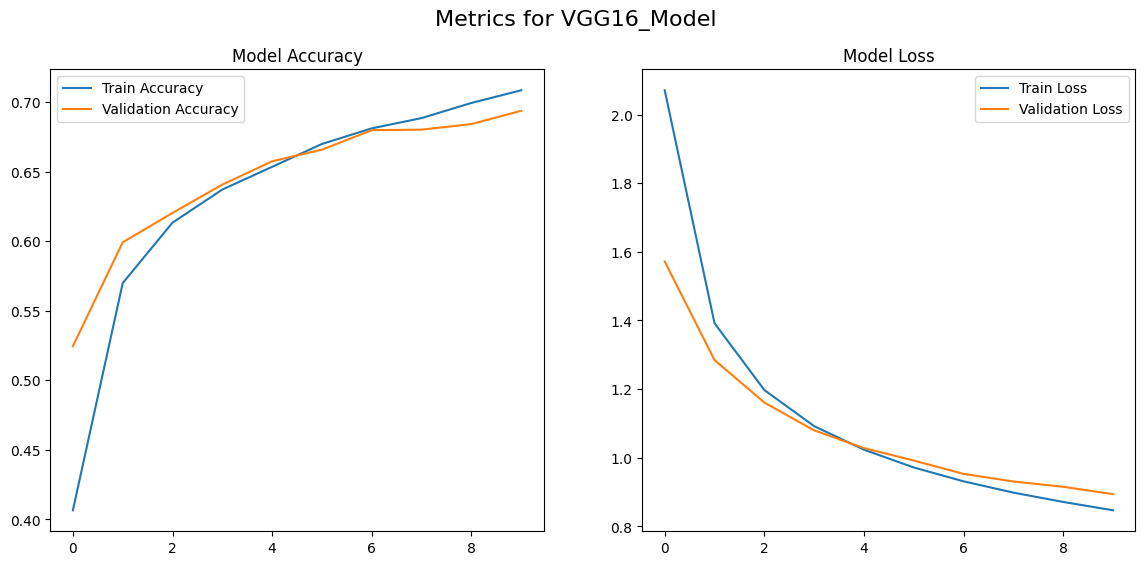

158/158 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.6867 - loss: 0.8749
2025-08-05 06:36:23,952 - INFO - VGG16 Test Accuracy: 69.08%


In [10]:
### Cell 10: Train VGG16 Model
logger.info("--- Training VGG16 Model ---")
if 'train_ds' in locals():
    base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model_vgg.trainable = False
    x = GlobalAveragePooling2D()(base_model_vgg.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    vgg_model = Model(inputs=base_model_vgg.input, outputs=predictions)
    vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    vgg_history = vgg_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=2)
    plot_graph(vgg_history, "VGG16_Model")
    loss, accuracy = vgg_model.evaluate(test_ds)
    results['VGG16'] = accuracy * 100
    logger.info(f"VGG16 Test Accuracy: {results['VGG16']:.2f}%")
else:
    logger.error("Skipping VGG16 training because data was not loaded.")

2025-08-05 06:36:23,962 - INFO - --- Training ResNet50 (Basic) Model ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
549/549 - 52s - 95ms/step - accuracy: 0.1294 - loss: 2.9038 - val_accuracy: 0.1581 - val_loss: 2.8450
Epoch 2/10
549/549 - 30s - 55ms/step - accuracy: 0.1583 - loss: 2.8024 - val_accuracy: 0.1489 - val_loss: 2.7550
Epoch 3/10
549/549 - 40s - 73ms/step - accuracy: 0.1892 - loss: 2.7056 - val_accuracy: 0.2040 - val_loss: 2.6597
Epoch 4/10
549/549 - 29s - 53ms/step - accuracy: 0.2124 - loss: 2.6258 - val_accuracy: 0.2423 - val_loss: 2.5945
Epoch 5/10
549/549 - 42s - 77ms/step - accuracy: 0.2305 - loss: 2.5644 - val_accuracy: 0.2467 - val_loss: 2.5483
Epoch 6/10
549/549 - 31s - 56ms/step - accuracy: 0.2462 - loss: 2.5127 - val_accuracy: 0.2575 - val_loss: 2.5015
Epoch 7/10
549/549 - 40s - 74ms/step - accuracy: 0.2576 - loss: 2.4711 - val_accuracy: 0.2683 - val_loss: 2.4598
Epoch 8/10
549/549 - 40s - 72ms/step - accuracy: 0.2682 - loss: 2.4361 - val_accuracy

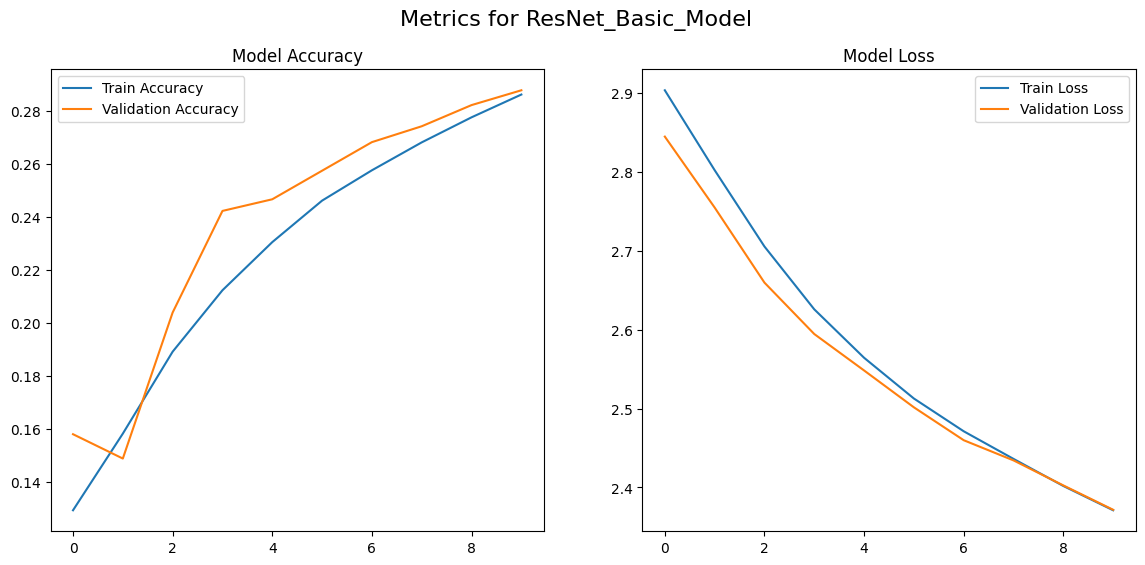

158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.2890 - loss: 2.3636
2025-08-05 06:43:15,581 - INFO - ResNet (Basic) Test Accuracy: 28.98%


In [11]:
### Cell 11: Train ResNet50 (Basic) Model
logger.info("--- Training ResNet50 (Basic) Model ---")
if 'train_ds' in locals():
    base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model_res.trainable = False
    x = GlobalAveragePooling2D()(base_model_res.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    res_model = Model(inputs=base_model_res.input, outputs=predictions)
    res_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    resnet_history = res_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=2)
    plot_graph(resnet_history, "ResNet_Basic_Model")
    loss, accuracy = res_model.evaluate(test_ds)
    results['ResNet_Basic'] = accuracy * 100
    logger.info(f"ResNet (Basic) Test Accuracy: {results['ResNet_Basic']:.2f}%")
else:
    logger.error("Skipping ResNet (Basic) training because data was not loaded.")

2025-08-05 06:43:15,593 - INFO - --- Training ResNet50 (Perfect) Model ---
Found 17567 images belonging to 22 classes.
Found 2505 images belonging to 22 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
549/549 - 230s - 418ms/step - accuracy: 0.2264 - loss: 16.7432 - val_accuracy: 0.0675 - val_loss: 18.3467
Epoch 2/15
549/549 - 145s - 263ms/step - accuracy: 0.4980 - loss: 15.0833 - val_accuracy: 0.7138 - val_loss: 14.1190
Epoch 3/15
549/549 - 146s - 266ms/step - accuracy: 0.6295 - loss: 14.1075 - val_accuracy: 0.7545 - val_loss: 13.4191
Epoch 4/15
549/549 - 144s - 263ms/step - accuracy: 0.6941 - loss: 13.3512 - val_accuracy: 0.7788 - val_loss: 12.7819
Epoch 5/15
549/549 - 144s - 262ms/step - accuracy: 0.7284 - loss: 12.6780 - val_accuracy: 0.7952 - val_loss: 12.1582
Epoch 6/15
549/549 - 144s - 262ms/step - accuracy: 0.7573 - loss: 11.9980 - val_accuracy: 0.8128 - val_loss: 11.5253
Epoch 7/15
549/549 - 146s - 265ms/step - accuracy: 0.7727 - loss: 11.3365 - val_accuracy: 0.8259 - val_loss: 10.8824
Epoch 8/15
549/549 - 144s - 263ms/step - accuracy: 0.7889 - loss: 10.6723 - val_accuracy: 0.8363 - val_loss: 10.2451
Epoch 9/15
549/549 - 145s - 264ms/step - accuracy: 0.8080 - loss

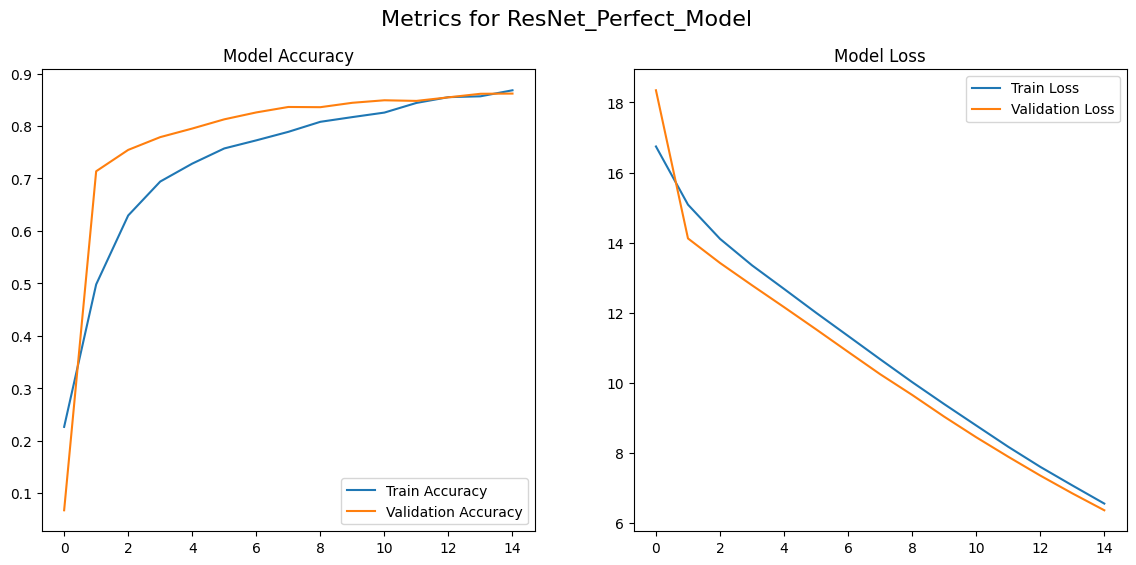

Found 5052 images belonging to 22 classes.
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9268 - loss: 6.1710
2025-08-05 07:21:15,876 - INFO - ResNet (Perfect) Test Accuracy: 87.63%
2025-08-05 07:21:15,877 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-08-05 07:21:17,085 - INFO - Saved the best model (ResNet-Perfect) as 'crop_pest_model.h5'


In [12]:
### Cell 12: Train ResNet50 (Perfect) Model
logger.info("--- Training ResNet50 (Perfect) Model ---")
if 'train_ds' in locals():
    datagen = ImageDataGenerator(
        rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest',
        rescale=1./255
    )
    train_generator = datagen.flow_from_directory(
        final_train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(
        final_val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
    )
    base_model_perfect = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in base_model_perfect.layers[-10:]:
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model_perfect.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    res_model_perfect = Model(inputs=base_model_perfect.input, outputs=predictions)
    res_model_perfect.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    res_model_perfect_history = res_model_perfect.fit(
        train_generator, epochs=15, validation_data=val_generator, callbacks=[early_stopping], verbose=2
    )
    plot_graph(res_model_perfect_history, "ResNet_Perfect_Model")
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        final_test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False
    )
    loss, accuracy = res_model_perfect.evaluate(test_generator)
    results['ResNet_Perfect'] = accuracy * 100
    logger.info(f"ResNet (Perfect) Test Accuracy: {results['ResNet_Perfect']:.2f}%")
    res_model_perfect.save('crop_pest_model.h5')
    logger.info("Saved the best model (ResNet-Perfect) as 'crop_pest_model.h5'")
else:
    logger.error("Skipping ResNet (Perfect) training because data was not loaded.")

In [13]:
### Cell 13: Final Results
# This cell prints a summary table of all model accuracies.

logger.info("--- FINAL MODEL EVALUATION RESULTS ---")
if 'results' in locals() and results:
    results_header = "--------------------------------------"
    logger.info(results_header)
    for model_name, acc in results.items():
        logger.info(f"| {model_name:<15} | {acc:>8.2f}% |")
    logger.info(results_header)
else:
    logger.warning("No results to display. Training may have failed.")

2025-08-05 07:21:17,111 - INFO - --- FINAL MODEL EVALUATION RESULTS ---
2025-08-05 07:21:17,113 - INFO - --------------------------------------
2025-08-05 07:21:17,114 - INFO - | ANN             |    30.21% |
2025-08-05 07:21:17,115 - INFO - | CNN             |    64.81% |
2025-08-05 07:21:17,116 - INFO - | VGG16           |    69.08% |
2025-08-05 07:21:17,117 - INFO - | ResNet_Basic    |    28.98% |
2025-08-05 07:21:17,118 - INFO - | ResNet_Perfect  |    87.63% |
2025-08-05 07:21:17,119 - INFO - --------------------------------------


In [14]:
# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']
